Feature hostgal_specz is removed
Dimension of merge data for MJD relevant data and META data  (1421705, 17)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (400574, 17) (1021131, 17)
Dimension of aggregated data on flux features (7848, 18)
Dimension of merge data for Object relevant data and META data (7848, 30)
Number of objects in galaxy : 2325
Number of objects out of galaxy : 5523
Just to check, sum of objects : 7848
Total number should be 7848
Dimension of merge data for that in galaxy and that out of galaxy  (2325, 30) (5523, 30)


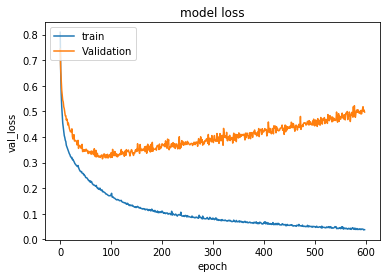

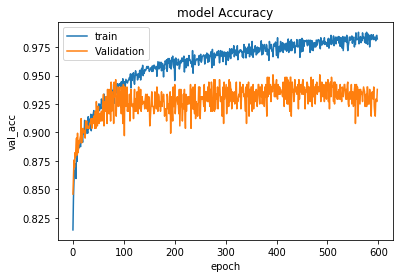

Loading Best Model
Number of classes : 5
0.31191280759888673


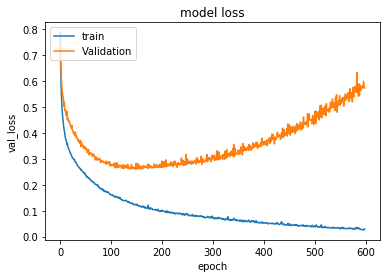

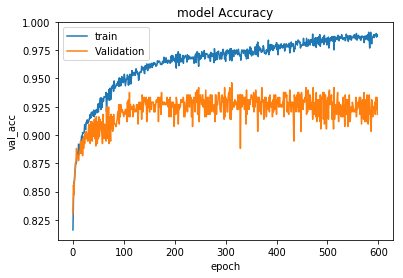

Loading Best Model
Number of classes : 5
0.2608072364608644


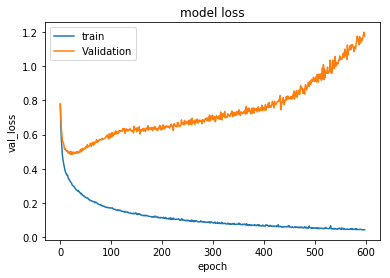

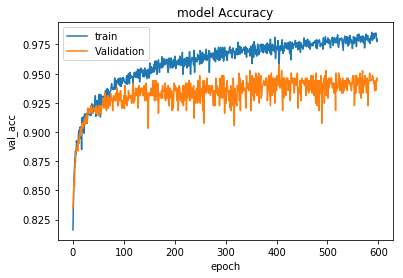

Loading Best Model
Number of classes : 5
0.10540113282133265


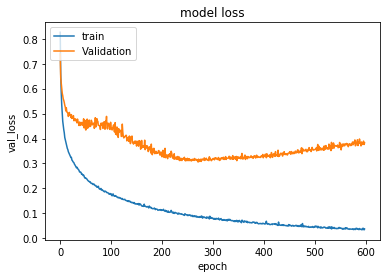

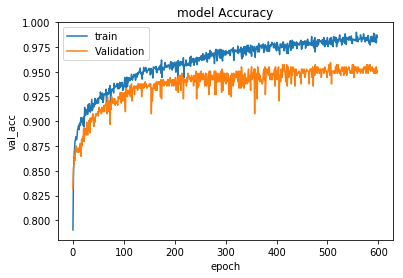

Loading Best Model
Number of classes : 5
0.12532361599028016


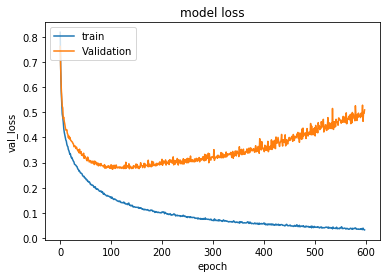

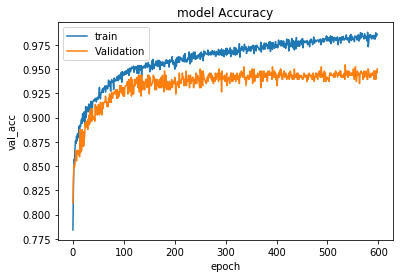

Loading Best Model
Number of classes : 5
0.1409996418971906
Number of classes : 5
MULTI WEIGHTED LOG LOSS : 0.18929 
[<keras.engine.sequential.Sequential object at 0x00000251965D7278>, <keras.engine.sequential.Sequential object at 0x000002518B9AB1D0>, <keras.engine.sequential.Sequential object at 0x000002518A701390>, <keras.engine.sequential.Sequential object at 0x000002519AFEBD30>, <keras.engine.sequential.Sequential object at 0x00000251C605BDA0>]


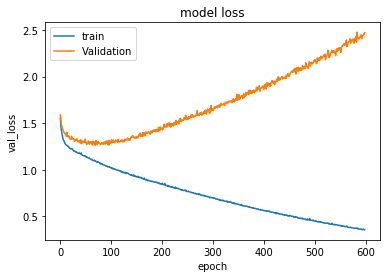

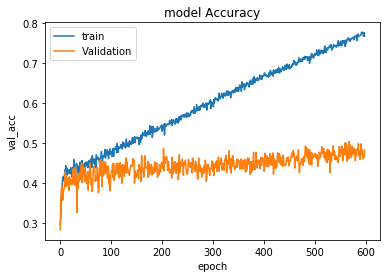

Loading Best Model
Number of classes : 9
1.1925571069112053


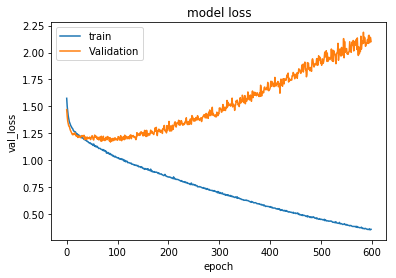

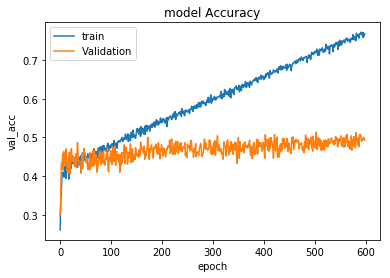

Loading Best Model
Number of classes : 9
1.1365801333051442


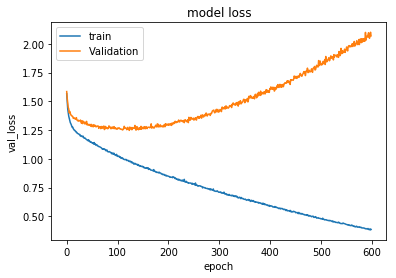

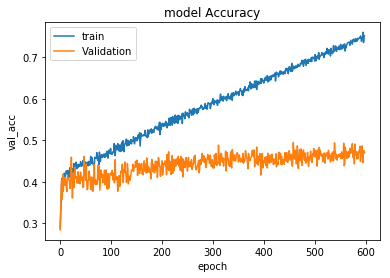

Loading Best Model
Number of classes : 9
0.9931608947771601


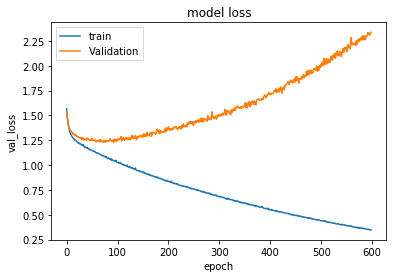

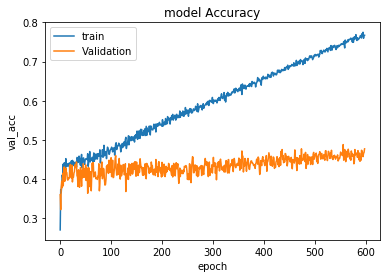

Loading Best Model
Number of classes : 9
0.9794558246803827


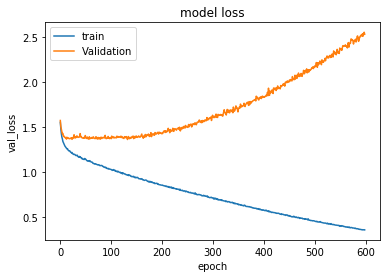

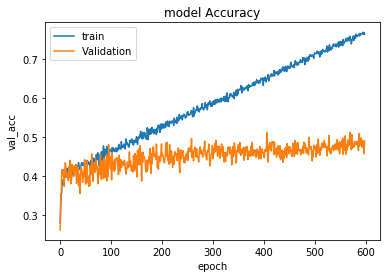

Loading Best Model
Number of classes : 9
0.9788284419909773
Number of classes : 9
MULTI WEIGHTED LOG LOSS : 1.05715 
[<keras.engine.sequential.Sequential object at 0x0000025196C352E8>, <keras.engine.sequential.Sequential object at 0x0000025187F36710>, <keras.engine.sequential.Sequential object at 0x000002519915EC88>, <keras.engine.sequential.Sequential object at 0x0000025195631320>, <keras.engine.sequential.Sequential object at 0x0000025187A87C88>]
Just double check: 0.7859421673015253
Number of classes : 14
MULTI WEIGHTED LOG LOSS : 0.78594 
               Model     Score
0       Galaxy_Model  0.189289
1  Extragalaxy_Model  1.057148
2           Bi_Model  0.785942


In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
import datetime

def multi_weighted_logloss_OLDVERSION(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    if len(np.unique(y_true)) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
#     if len(np.unique(y_true)) > 14:
#         classes.append(99)
#         class_weight[99] = 2
        
    # Galaxy Case
    if len(np.unique(y_true)) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(np.unique(y_true)) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}    
        
        
        
        
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss
    
def set_df(arr, col_names):
    df = pd.DataFrame(arr)
    df.columns = col_names
    return df

def get_new_columns(aggs):
    return [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

def agg_by_flux_feats(df):
    
    df['flux_ratio'] = df['flux'] / df['flux_err']
    
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs = {
#         'mjd': ['min', 'max', 'size'],
#         'passband': ['mean', 'std', 'var'],  
        'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std'],
        'flux_ratio': ['min', 'max', 'mean', 'std'],
        'detected': ['mean'],  # ''min', 'max', 'mean', 'median', 'std'],
    }   

#     aggs['flux_ratio_sq'] = ['sum']
#     aggs['flux_by_flux_ratio_sq'] = ['sum']

    
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = get_new_columns(aggs)
    agg_df.columns = new_columns

    agg_df = add_flux_second_order_features_to_agg(df=agg_df)
    
    return agg_df

def add_flux_second_order_features_to_agg(df):
#     df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
#     df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
#     df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

#     del df['mjd_max'], df['mjd_min']

    return df


def get_by_galaxy(df):
    df_in_gal = df[df['in_galaxy']==1]
    objects_in_gal = df_in_gal['object_id'].unique().tolist()
    print('Number of objects in galaxy :',len(objects_in_gal))
    
    df_out_gal = df[df['in_galaxy']==0]
    objects_out_gal = df_out_gal['object_id'].unique().tolist()
    print('Number of objects out of galaxy :',len(objects_out_gal))
    print('Just to check, sum of objects :', len(objects_in_gal) + len(objects_out_gal))
    print('Total number should be', len(df['object_id'].unique().tolist()))
    return df_in_gal, df_out_gal


def add_feats_within_time_interval_out(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
#                                                                           'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
#                                                                          'interval_{}_flux_skew'.format(i+1):'skew'
                                                                        })
#         print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
#     # interval_#_flux_？ 互相做差
#     for key in ['max', 'min', 'mean']:
# #     for key in ['mean']:
#         key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
#         for col in key_cols:
#             subtract_cols = [col_ for col_ in key_cols if col_ < col]
#             for sub_col in subtract_cols:
#                 df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

def add_feats_within_time_interval(int_n, df, db):
    print('Number of Intervals :', int_n)
    t_min = db.mjd.min()
    t_max = db.mjd.max()
    print('Min and Max MJD time : {}, {}'.format(t_min, t_max))    
    int_dur = (t_max - t_min)/int_n
    for i in range(int_n):
        
        db_fil = db[(db.mjd>=(t_min+i*int_dur))&(db.mjd<(t_min + (i+1)*int_dur))][['object_id','flux','passband']]
        print('Interval #{}, record quantity: {}'.format(i+1, db_fil.shape[0]))
        
        # interval_#_flux_？
        stats = db_fil.groupby('object_id', as_index=False)['flux'].agg({'interval_{}_flux_mean'.format(i+1):'mean',
                                                                          'interval_{}_flux_std'.format(i+1):'std',
                                                                          'interval_{}_flux_min'.format(i+1):'min',
                                                                          'interval_{}_flux_max'.format(i+1):'max',
                                                                         'interval_{}_flux_skew'.format(i+1):'skew'})
#         print('New features added: ',stats.columns.tolist())
        df = df.merge(stats, on='object_id', how='left')
        
        
#         # interval_#_band_#_flux_？
#         stats = db_fil.groupby(['object_id','passband'])['flux'].skew().unstack()
#         stats.columns = ['interval_{}_band_{}_flux_skew'.format(i+1, str(col)) for col in stats.columns.tolist()]
#         print('Feats added:',stats.columns.tolist())
#         stats['object_id'] = stats.index    
#         df = df.merge(stats, on='object_id', how='left').fillna(0) 
        
                
    # interval_#_flux_？ 互相做差
    for key in ['max', 'min', 'mean']:
#     for key in ['max']:
        key_cols = ['interval_{}_flux_{}'.format(i, key) for i in range(1, int_n+1)]
        for col in key_cols:
            subtract_cols = [col_ for col_ in key_cols if col_ < col]
            for sub_col in subtract_cols:
                df['{}_minus_{}'.format(col, sub_col)] = df[col] - df[sub_col]
#                 print('Feature added:', '{}_minus_{}'.format(col, sub_col))
        

    
    print('Dimension of data after adding features relevant to time intervals', df.shape)
    
    return df

def add_band_feats(df, db):
    
    
### 均值
    print('Adding feats for the flux mean per band...')
    stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
    stats.columns = ['band_' + str(col) + '_flux_mean' for col in stats.columns.tolist()]
    
    # band_#_flux_mean互相减去
    mean_cols = stats.columns.tolist()
    for col in mean_cols:
        subtract_cols = [col_ for col_ in mean_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
      
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
### 标准差    
    print('Adding feats for the flux std per band...')
    stats = db.groupby(['object_id','passband'])['flux'].std().unstack()
    stats.columns = ['band_' + str(col) + '_flux_std' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0)

    
### 偏度    
    print('Adding feats for the flux skew per band...')
    stats = db.groupby(['object_id','passband'])['flux'].skew().unstack()
    stats.columns = ['band_' + str(col) + '_flux_skew' for col in stats.columns.tolist()]
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

### 最大值
    print('Adding feats for the flux max per band...')
    stats = db.groupby(['object_id','passband'])['flux'].max().unstack()
    stats.columns = ['band_' + str(col) + '_flux_max' for col in stats.columns.tolist()]
    # band_#_flux_max互相减去
    max_cols = stats.columns.tolist()
    for col in max_cols:
        subtract_cols = [col_ for col_ in max_cols if col_ < col]
        for sub_col in subtract_cols:
            stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
### 最小值    
    print('Adding feats for the flux min per band...')
    stats = db.groupby(['object_id','passband'])['flux'].min().unstack()
    stats.columns = ['band_' + str(col) + '_flux_min' for col in stats.columns.tolist()]
    
#     # band_#_flux_min互相做差
#     min_cols = stats.columns.tolist()
#     for col in min_cols:
#         subtract_cols = [col_ for col_ in min_cols if col_ < col]
#         for sub_col in subtract_cols:
#             stats['{}_minus_{}'.format(col, sub_col)] = stats[col] - stats[sub_col]
            
    # print('Feats added:',stats.columns.tolist())
    stats['object_id'] = stats.index    
    df = df.merge(stats, on='object_id', how='left').fillna(0) 
    

    
    
# ### ......  Mean
#     print('Adding feats for the flux_err mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux_err'].mean().unstack()
#     stats.columns = ['band_' + str(col) + '_flux_err_mean' for col in stats.columns.tolist()]      
#     print('Feats added:',stats.columns.tolist())
#     stats['object_id'] = stats.index    
#     df = df.merge(stats, on='object_id', how='left').fillna(0)
    
    
    
    
### 遍历band_list计算 
    print('Adding feats for the flux (max-min)/mean per band...')
    for band_n in range(6):
        df['band_' + str(band_n) + '_flux_diff1'] = df['band_' + str(band_n) + '_flux_max'] - df['band_' + str(band_n) + '_flux_min']
        df['band_' + str(band_n) + '_flux_diff2'] = df['band_' + str(band_n) + '_flux_diff1']/df['band_' + str(band_n) + '_flux_mean']
        # print('Feature added: band_' + str(band_n) + '_flux_diff2')
        
#         df['band_' + str(band_n) + '_flux_err_ratio'] = df['band_' + str(band_n) + '_flux_err_mean']/df['band_' + str(band_n) + '_flux_mean']
#         print('Feature added: band_' + str(band_n) + '_flux_err_ratio')
        
        
        

    


    print('Dimension of data after adding features relevant to bands', df.shape)
    
    return df

    
#     print('Adding feats for the flux mean per band...')
#     stats = db.groupby(['object_id','passband'])['flux'].mean().unstack()
#     stats['object_id'] = stats.index
#     stats.columns = [str(col) + '_mean' for col in stats.columns.tolist()]
#     df = df.merge(db, on='object_id', how='left').fillna(0)
#     print('Feats added:',stats.columns.tolist())

def add_flux_second_order_features_to_agg(df):
#     df['mjd_diff'] = df['mjd_max'] - df['mjd_min']
    df['flux_diff'] = df['flux_max'] - df['flux_min']
    df['flux_dif2'] = (df['flux_max'] - df['flux_min']) / df['flux_mean']
#     df['flux_w_mean'] = df['flux_by_flux_ratio_sq_sum'] / df['flux_ratio_sq_sum']
#     df['flux_dif3'] = (df['flux_max'] - df['flux_min']) / df['flux_w_mean']

#     del df['mjd_max'], df['mjd_min']

    return df

def add_photo_feats(df):
    df['hostgal_photoz_ratio'] = df['hostgal_photoz']/df['hostgal_photoz_err']
    
    return df



def fabriquer_feat(db, meta):
    
    # # 去除无效特征
    # del meta['hostgal_specz']
    # print('Feature hostgal_specz is removed')
    
    # META数据提供划分银河系内外的依据
    # 增加是否属于银河系的特征
    meta.distmod.fillna(0,inplace=True)
    meta['in_galaxy'] = 0
    meta.loc[(meta.distmod == 0), 'in_galaxy'] = 1
    
    # 时序数据和META数据融合，形成以mjd为行的数据
    db_meta = db.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for MJD relevant data and META data ', db_meta.shape)
    
    # 对时序融合数据进行分割
    db_in_gal, db_out_gal = get_by_galaxy(db_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', db_in_gal.shape, db_out_gal.shape)
    
    # 基本特征聚合
    agg_df = agg_by_flux_feats(db)
    print('Dimension of aggregated data on flux features', agg_df.shape)
    
    # 聚合数据和META数据融合，形成以object_id为行的数据
    agg_df_meta = agg_df.merge(meta, on='object_id', how='left')
    print('Dimension of merge data for Object relevant data and META data', agg_df_meta.shape)

    # 对object融合数据进行分割
    df_in_gal, df_out_gal = get_by_galaxy(agg_df_meta)
    print('Dimension of merge data for that in galaxy and that out of galaxy ', df_in_gal.shape, df_out_gal.shape)

    
    # 对银河系内外数据分别提取特征
    print('Features extraction begins...')
    
    # 银河系内
    print('In terms of that in the Galaxy...')
    
    # 增加band相关特征
    df_in_gal = add_band_feats(df_in_gal, db_in_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_in_gal = add_feats_within_time_interval(6, df_in_gal, db_in_gal)
    
    # 银河系外
    print('In terms of that out of the Galaxy...')
    
    # 增加hostgal_photoz相关特征
    df_out_gal = add_photo_feats(df_out_gal)
    
    # 增加band相关特征
    df_out_gal = add_band_feats(df_out_gal, db_out_gal)    
    
    # 增加按MJD划分时间统计得到的特征
    df_out_gal = add_feats_within_time_interval_out(6, df_out_gal, db_out_gal) 
    
    return df_in_gal, df_out_gal
    
    
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix


def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
#     classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
#     class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}

    print('Number of classes :', len(y_ohe[0]))
    
    if len(y_ohe[0]) == 14:
        classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
        class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    
    # Galaxy Case
    if len(y_ohe[0]) == 5:
        classes = [6, 16, 53, 65, 92]
        class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
        
    # Out of Galaxy Case
    if len(y_ohe[0]) == 9:
        classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
        class_weight = {15: 2, 42: 1, 52: 1, 62: 1, 64: 2, 67: 1, 88: 1, 90: 1, 95: 1}
        
        
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss



def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    

def to_cat(y):    
    classes = sorted(np.unique(y))
    
    unique_y = np.unique(y)
    class_map = dict()

    for i,val in enumerate(unique_y):
        class_map[val] = i            
    y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y])
    y_categorical = to_categorical(y_map)    
    
    return y_categorical
    
    
    
def train_by_nn(full_train, y):
    full_train_new = full_train.copy()
    ss = StandardScaler()
    full_train_ss = ss.fit_transform(full_train_new)
    
    classes = sorted(y.unique())
    
    unique_y = np.unique(y)
    class_map = dict()

    for i,val in enumerate(unique_y):
        class_map[val] = i            
    y_map = np.zeros((y.shape[0],))
    y_map = np.array([class_map[val] for val in y])
    y_categorical = to_categorical(y_map)    

    
    y_count = Counter(y_map)
    wtable = np.zeros((len(unique_y),))
    for i in range(len(unique_y)):
        wtable[i] = y_count[i]/y_map.shape[0]    
    
    
    def mywloss(y_true, y_pred):  
  
        yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
        loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
        return loss
    
#     K.clear_session()
    def build_model(dropout_rate=0.25,activation='relu'):
        start_neurons = 512
        # create model
        model = Sequential()
        model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//2,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//4,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        model.add(Dense(start_neurons//8,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate/2))
        
        model.add(Dense(len(classes), activation='softmax'))
        return model    
    
        
    clfs = []
    oof_preds = np.zeros((len(full_train_ss), len(classes)))
    epochs = 600
    batch_size = 100
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
        x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
        x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
        
        model = build_model(dropout_rate=0.5,activation='tanh')    
        model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
        history = model.fit(x_train, y_train,
                        validation_data=[x_valid, y_valid], 
                        epochs=epochs,
                        batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
        
        plot_loss_acc(history)
        
        print('Loading Best Model')
        model.load_weights('./keras.model')
        # # Get predicted probabilities for each class
        oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
        print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
        clfs.append(model)
    
    return ss, y_categorical, oof_preds, clfs


gc.enable()

train = pd.read_csv('../input/training_set.csv')

meta_train = pd.read_csv('../input/training_set_metadata.csv')

# 去除无效特征
del meta_train['hostgal_specz']
print('Feature hostgal_specz is removed')

full_train_in_gal, full_train_out_gal = fabriquer_feat(train, meta_train)

for df in [full_train_in_gal, full_train_out_gal]:
    del df['object_id']
    df_mean = df.mean(axis=0)
    df.fillna(df_mean, inplace=True)

del train

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

y_in_gal = full_train_in_gal['target']

train_in_gal = full_train_in_gal.copy()

del train_in_gal['target']

# print('Training begins...')

val_score_list = []
clf_list = []

ss_in, y_categorical_in_gal, oof_preds_in_gal, clf_in = train_by_nn(train_in_gal, y_in_gal)

score_in_gal = multi_weighted_logloss(y_categorical_in_gal,oof_preds_in_gal)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % score_in_gal)
val_score_list.append(score_in_gal)
print(clf_in)
clf_list.append(clf_in)


y_out_gal = full_train_out_gal['target']

train_out_gal = full_train_out_gal.copy()

del train_out_gal['target']

ss_out, y_categorical_out_gal, oof_preds_out_gal, clf_out = train_by_nn(train_out_gal, y_out_gal)

score_out_gal = multi_weighted_logloss(y_categorical_out_gal,oof_preds_out_gal)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % score_out_gal)
val_score_list.append(score_out_gal)
clf_list.append(clf_out)
print(clf_out)

all_y = np.concatenate((y_in_gal.values, y_out_gal.values), axis=0)

in_classes = [6, 16, 53, 65, 92]
out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]

in_df = set_df(oof_preds_in_gal, in_classes)
out_df = set_df(oof_preds_out_gal, out_classes)
in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)


print('Just double check:', multi_weighted_logloss_OLDVERSION(y_true=all_y, y_preds=in_out_df.values))

all_y_cat = to_cat(all_y)

tot_score = multi_weighted_logloss(all_y_cat, in_out_df.values)
print('MULTI WEIGHTED LOG LOSS : %.5f ' % tot_score)

val_score_list.append(tot_score)



score_tab = pd.DataFrame({'Model':['Galaxy_Model', 'Extragalaxy_Model','Bi_Model'], 'Score':val_score_list})
print(score_tab)


# 结果存档
# score_tab.to_csv(r'../feat/validation_scores_{}.csv'.format(datetime.datetime.now().strftime('%m%d_%H%M')), index=False)


# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     fig = plt.figure(figsize=(20,10))
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
    
#     fig.savefig(r'../feat/confusion_matrix_{}.pdf'.format(datetime.datetime.now().strftime('%m%d_%H%M')))
    
    

# def get_confusion_matrix(y, preds):
#     unique_y = np.unique(y)
#     class_map = dict()
#     for i,val in enumerate(unique_y):
#         class_map[val] = i
            
# #     y_map = np.zeros((y.shape[0],))
#     y_map = np.array([class_map[val] for val in y]) 
    
#     cnf_matrix = confusion_matrix(y_map, np.argmax(preds, axis=-1))  
#     np.set_printoptions(precision=2)
    
    
#     sample_sub = pd.read_csv('../input/sample_submission.csv')
#     class_names = list(sample_sub.columns[1:-1])
#     del sample_sub;gc.collect()
    
#     # Plot non-normalized confusion matrix
#     plt.figure(figsize=(10,10))
#     foo = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                           title='Confusion matrix')
    

# get_confusion_matrix(all_y, in_out_df.values)   


# def predict_chunk(df_, clfs_, meta_, features, train_mean):
    
#     print('Chunk size',df_.shape[0])
    

#     full_test_in_gal, full_test_out_gal = fabriquer_feat(df_, meta_)
        


#     in_classes = [6, 16, 53, 65, 92]
#     out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95] 

#     if full_test_in_gal.shape[0] == 0:
#         in_df = pd.DataFrame(columns=in_classes)
#         in_ids = []
        
    
#     else :
#         in_ids = full_test_in_gal['object_id'].astype(np.int64).values
        
#         del full_test_in_gal['object_id']
#         df_mean = full_test_in_gal.mean(axis=0)
#         full_test_in_gal.fillna(df_mean, inplace=True)
    
#         # Make predictions in galaxy
#         preds_in_gal = None
#         for clf in clfs_[0]:
#             if preds_in_gal is None:
#                 preds_in_gal = clf.predict_proba(full_test_in_gal[features[0]]) / len(clfs_[0])
#             else:
#                 preds_in_gal += clf.predict_proba(full_test_in_gal[features[0]]) / len(clfs_[0])
        
#         in_df = set_df(preds_in_gal, in_classes)
        
            

#     if full_test_out_gal.shape[0] == 0:
#         out_df = pd.DataFrame(columns=out_classes)    
#         out_ids = []
    
#     else :
#         out_ids = full_test_out_gal['object_id'].astype(np.int64).values
        
#         del full_test_out_gal['object_id']
#         df_mean = full_test_out_gal.mean(axis=0)
#         full_test_out_gal.fillna(df_mean, inplace=True)
                
#         # Make predictions out of galaxy
#         preds_out_gal = None
#         for clf in clfs_[1]:
#             if preds_out_gal is None:
#                 preds_out_gal = clf.predict_proba(full_test_out_gal[features[1]]) / len(clfs_[1])
#             else:
#                 preds_out_gal += clf.predict_proba(full_test_out_gal[features[1]]) / len(clfs_[1])
        
#         out_df = set_df(preds_out_gal, out_classes)
        
#     # Merge predictions
#     in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)
#     print(in_out_df.shape)
    
#     preds_ = in_out_df.values
    
            
#     # Compute preds_99 as the proba of class not being any of the others
#     # preds_99 = 0.1 gives 1.769
#     preds_99 = np.ones(preds_.shape[0])
#     for i in range(preds_.shape[1]):
#         preds_99 *= (1 - preds_[:, i])

#     # Create DataFrame from predictions
#     classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
# #     preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
#     preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in classes])
#     preds_df_['object_id'] = np.concatenate((in_ids,out_ids), axis=0)
#     preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

#     print(preds_df_['class_99'].mean())

#     del full_test_in_gal, full_test_out_gal, preds_, in_out_df
#     gc.collect()

#     return preds_df_
    
    


In [33]:
def predict_chunk(df_, clf_in, clf_out, meta_, features, ss_in, ss_out, train_mean):
    
    print('Chunk size',df_.shape[0])
    

    full_test_in_gal, full_test_out_gal = fabriquer_feat(df_, meta_)
        


    in_classes = [6, 16, 53, 65, 92]
    out_classes = [15, 42, 52, 62, 64, 67, 88, 90, 95] 

    if full_test_in_gal.shape[0] == 0:
        in_df = pd.DataFrame(columns=in_classes)
        in_ids = []
        
    
    else :
        in_ids = full_test_in_gal['object_id'].astype(np.int64).values
        
        del full_test_in_gal['object_id']
        df_mean = full_test_in_gal.mean(axis=0)
        full_test_in_gal.fillna(df_mean, inplace=True)
        ss_in_gal = ss_in.transform(full_test_in_gal[features[0]])
    
        # Make predictions in galaxy
        preds_in_gal = None
        for clf in clf_in:
            if preds_in_gal is None:
                preds_in_gal = clf.predict_proba(ss_in_gal) / len(clf_in)
            else:
                preds_in_gal += clf.predict_proba(ss_in_gal) / len(clf_in)
        
        print(preds_in_gal)
        in_df = set_df(preds_in_gal, in_classes)
        
            

    if full_test_out_gal.shape[0] == 0:
        out_df = pd.DataFrame(columns=out_classes)    
        out_ids = []
    
    else :
        out_ids = full_test_out_gal['object_id'].astype(np.int64).values
        
        del full_test_out_gal['object_id']
        df_mean = full_test_out_gal.mean(axis=0)
        full_test_out_gal.fillna(df_mean, inplace=True)
        ss_out_gal = ss_out.transform(full_test_out_gal[features[1]])
                
        # Make predictions out of galaxy
        preds_out_gal = None
        for clf in clf_out:
            if preds_out_gal is None:
                preds_out_gal = clf.predict_proba(ss_out_gal) / len(clf_out)
            else:
                preds_out_gal += clf.predict_proba(ss_out_gal) / len(clf_out)
        
        out_df = set_df(preds_out_gal, out_classes)
        
    # Merge predictions
    in_out_df = pd.concat([in_df, out_df], axis=0).fillna(0)
    print(in_out_df.shape)
    
    preds_ = in_out_df.values
    
            
    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    
#     preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in classes])
    preds_df_['object_id'] = np.concatenate((in_ids,out_ids), axis=0)
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

    print(preds_df_['class_99'].mean())

    del full_test_in_gal, full_test_out_gal, preds_, in_out_df
    gc.collect()

    return preds_df_

In [35]:
meta_test = pd.read_csv('../input/test_set_metadata.csv')
# 去除无效特征
del meta_test['hostgal_specz']
print('Feature hostgal_specz is removed')

import time

start = time.time()
chunks = 5000000
# chunks = 100000
remain_df = None

for i_c, df in enumerate(pd.read_csv('../input/test_set.csv', chunksize=chunks, iterator=True)):
    # Check object_ids
    # I believe np.unique keeps the order of group_ids as they appear in the file
    unique_ids = np.unique(df['object_id'])
    # 最后一个ID的内容
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()

    if remain_df is None:
        #  除最后一个ID外的内容
        df = df.loc[df['object_id'].isin(unique_ids[:-1])].copy()
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)

    # Create remaining samples df
    remain_df = new_remain_df
    
    

    preds_df = predict_chunk(df_=df,
                             clf_in=clf_in, clf_out=clf_out,
                             meta_=meta_test,
                             features=[train_in_gal.columns, train_out_gal.columns],
                             ss_in=ss_in, ss_out=ss_out, train_mean=None) 

    if i_c == 0:
        preds_df.to_csv('predictions_v3.csv', header=True, index=False, float_format='%.6f')
    else:
        preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

    del preds_df
    gc.collect()

    if (i_c + 1) % 1 == 0:
        # get_logger().info('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
        # print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))
        print('Progress percentage : %5.2f' % (chunks * (i_c + 1)/500000000))
        print('Time estimated left : %5.2f' % ((time.time() - start) / 60 * (500000000-chunks * (i_c + 1))/(chunks * (i_c + 1))))

# Compute last object in remain_df

preds_df = predict_chunk(df_=remain_df,
                         clf_in=clf_in, clf_out=clf_out,
                         meta_=meta_test,
                         features=[train_in_gal.columns, train_out_gal.columns],
                         ss_in=ss_in, ss_out=ss_out, train_mean=None)

preds_df.to_csv('predictions_v3.csv', header=False, mode='a', index=False, float_format='%.6f')

z = pd.read_csv('predictions_v3.csv')

z = z.groupby('object_id').mean()

z.to_csv('single_predictions_v3.csv', index=True, float_format='%.6f')

z = z.astype(np.float32)

z['object_id'] = z.index.astype(np.int32)

z = z.drop_duplicates(subset=['object_id'], keep='first')

z.to_csv('single_predictions_v3.gz', index=False, float_format='%.6f', compression='gzip')

Feature hostgal_specz is removed
Chunk size 99737
Dimension of merge data for MJD relevant data and META data  (99737, 16)
Number of objects in galaxy : 4
Number of objects out of galaxy : 301
Just to check, sum of objects : 305
Total number should be 305
Dimension of merge data for that in galaxy and that out of galaxy  (1309, 16) (98428, 16)
Dimension of aggregated data on flux features (305, 18)
Dimension of merge data for Object relevant data and META data (305, 29)
Number of objects in galaxy : 4
Number of objects out of galaxy : 301
Just to check, sum of objects : 305
Total number should be 305
Dimension of merge data for that in galaxy and that out of galaxy  (4, 29) (301, 29)
[<keras.engine.sequential.Sequential object at 0x00000251965D7278>, <keras.engine.sequential.Sequential object at 0x000002518B9AB1D0>, <keras.engine.sequential.Sequential object at 0x000002518A701390>, <keras.engine.sequential.Sequential object at 0x000002519AFEBD30>, <keras.engine.sequential.Sequential ob

Dimension of merge data for MJD relevant data and META data  (99839, 16)
Number of objects in galaxy : 0
Number of objects out of galaxy : 304
Just to check, sum of objects : 304
Total number should be 304
Dimension of merge data for that in galaxy and that out of galaxy  (0, 16) (99839, 16)
Dimension of aggregated data on flux features (304, 18)
Dimension of merge data for Object relevant data and META data (304, 29)
Number of objects in galaxy : 0
Number of objects out of galaxy : 304
Just to check, sum of objects : 304
Total number should be 304
Dimension of merge data for that in galaxy and that out of galaxy  (0, 29) (304, 29)
[<keras.engine.sequential.Sequential object at 0x0000025196C352E8>, <keras.engine.sequential.Sequential object at 0x0000025187F36710>, <keras.engine.sequential.Sequential object at 0x000002519915EC88>, <keras.engine.sequential.Sequential object at 0x0000025195631320>, <keras.engine.sequential.Sequential object at 0x0000025187A87C88>]
(304, 14)
0.14
         